### HEO Model - Genset(s) and Batterie(s). 
====================================
$ 
\\
$

$ 
\\
$

### Importing modules.

In [1]:
from src.functions.fuel_consumption import fuelCon
from src.functions.load_window import lwd 
from IPython.display import Image
import plotly.express as px
import pandas as pd
import numpy as np
from pulp import *

0.001*FOC_0 + 0.001*FOC_1 + 0.001*FOC_2 + 0.001*FOC_3 + 0.001*FOC_4 + 0.001*FOC_5 + 0.001*FOC_6 + 0.001*FOC_7 + 0.001*FOC_8 + 0.001*FOC_9
Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 100 rows, 99 columns and 247 nonzeros
Model fingerprint: 0xc6d66fdd
Variable types: 60 continuous, 39 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+02]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+00, 2e+04]
Presolve removed 80 rows and 77 columns
Presolve time: 0.07s
Presolved: 20 rows, 22 columns, 62 nonzeros
Variable types: 12 continuous, 10 integer (10 binary)
Found heuristic solution: objective 421.7466380

Root relaxation: objective 4.216701e+02, 3 itera

$\newline $

<em>The core objective of this solution is to reduce the amount of fuel consumed by the genset during the ship trip, and therfore based on the linearized SFOC engine characteristic curve of a typical hyperbolic model we need to keep as possible the engine loaded near to its maximum power  in order to keep the FOC (fuel oil consumption) as low as possible (see the curve bellow). Beside of the fact that maximizing power will reduce the FOC per time step, we aim also in this solution to optimize further the fuel oil consumption by integrating a storage battery system that allows turning off completely the genset when we have enough energy stored and therefore avoiding the additional costs due to burning extra fuel just to keep the genset running at its optimal load.</em> 

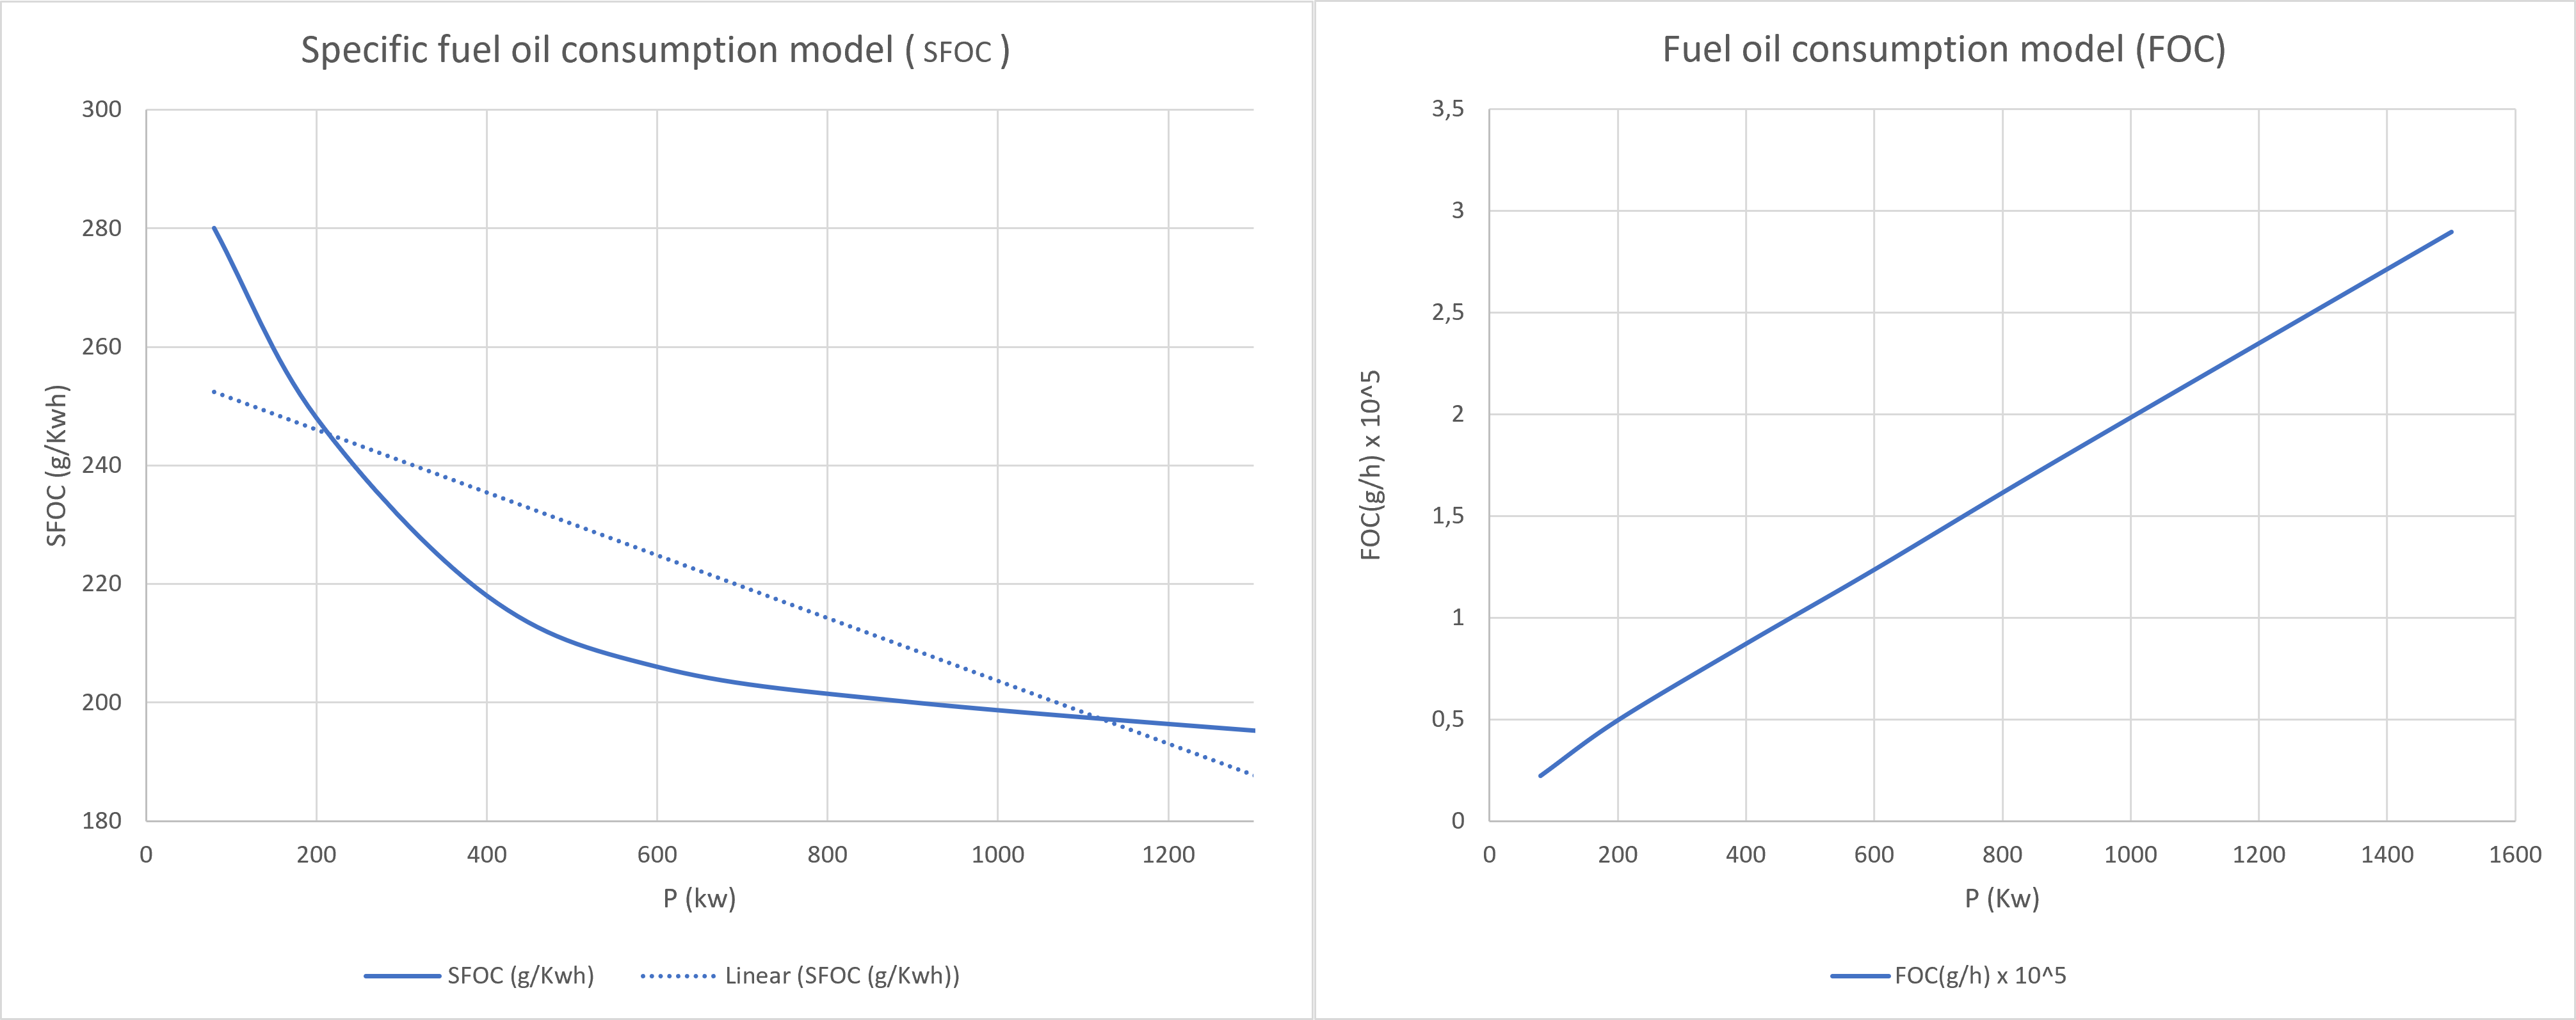

In [2]:
Image("../mkdocs/docs/img/sfoc_foc_characteristic.png",width=1500,height=1500,embed=True,)

$\newline $
### Introducing problem parameters.

In [10]:
Q_max = 10                                                   # maximal capacity stored on battery.
Q_0 = 0.1*Q_max                                               # inital capacity stored on battery.
Q_final = 0.2*Q_max                                           # Final capacity stored on the battery. 
eff_to_bss = 0.9                                             # battery charging efficiency.
eff_from_bss = 0.9                                           # battery transfer efficiency. 
P_max = 15                                                    # max output from gen set A.
P_min = 0                                                     # min output from gen set A.        
dt = 1                                                        # simulation time step dt.
t_max = 10                                                    # time span for simulation = t_max hours.
t = np.atleast_2d(np.arange(0,t_max,dt)).T.conj()             # time scale in hours.
n = len(t)                                                    # number of time steps.
m = 1                                                         # number of Gensets used on the trip, 1 is used.
fc_offset = 190                                               # genset j fuel consumption when no power gnerated (p=0) in g/h.
V_steps = [x for x in range(0,n)]                             # Time steps vector. 
V_steps_z = V_steps[:-1]                                      # Time steps vector without the final step. 
Q_h = 135000                                                  # Estimated heat loss when temp drops. 1 kJ/h = 0.0002777778 kW
T_H = 21                                                      # Inside temperature (°C) (barn temperature). 

P_pv30 = {0:1.5, 1:1.2, 2:0.5, 3:0.8, 4:0.9, 5:1.1, 6:1.6, 7:0.9, 8:1.3, 9:2}
P_pv60 = {0:1.2, 1:1.1, 2:0.9, 3:0.8, 4:1.6, 5:1.1, 6:1.6, 7:1.8, 8:1.5, 9:2}
P_wind = {0:1, 1:1.9, 2:3, 3:0.8, 4:0.9, 5:10, 6:8.8, 7:0.9, 8:1.3, 9:2}


L = lwd (5, 3, 5,                                          # Typical Power requirement window.
                5, 10, 5,
                2, 1.5, 10,
                1.5, 2.5, 30,
                0, 5, 20, 30)                                 
'''
L = lwd (10, 5, 8,                                          # Typical Power requirement window.
                3, 2, 9,
                4, 9, 6,
                3, 7, 30,
                0, 5, 20, 30)   
'''

P_pv30_max = 2                                                      # (Irr_sol[k]*S_pv30 for k in V_steps)  Maximal power generated by Solar PV modules tilted by 30° (for maximal irradiance (W/m^2).
P_pv30_min = 0                                                      # Minimal power generated by Solar PV modules tilted by 30° (at night irradiance = 0 W/m^2).
P_pv60_max = 2                                                      # (Irr_sol[k]*S_pv60 for k in V_steps)  Maximal power generated by Solar PV modules tilted by 60° (for maximal irradiance (W/m^2).
P_pv60_min = 0                                                      # Minimal power generated by Solar PV modules tilted by 60° (at night irradiance = 0 W/m^2).
P_wind_max = 11                                                      # (1/2*V_wind[k]*Cp*rho*math.pi*R**2 for k in V_steps) Maximal power generated by the wind turbine (cut-out wind speed (kwh).  P = 0.5 Cp ρ π R2 V3
P_wind_min = 0	                                                    # Minimal power generated by the wind turbine (cut-in wind speed (kwh).
P_hp_max = 1.1                                                      # (Q_h / 1 / (1 - T_L[k] / T_H) for k in V_steps) Maximal power transferred to Meteoria barn’s heat pumps (kwh).
P_hp_min = 	0                                                       # Minimal power transferred to Meteoria barn’s heat pumps (kwh).
P_sh_max =  5.1	                                                    # Maximal power transferred to the space heater (kwh).
P_sh_min =	0                                                       # Minimal power transferred to the space heater (kwh).
P_bio_max =	1.2                                                       # Maximal power generated by biomeiler compost heater (kwh).
P_bio_min =	0                                                       # Minimal power generated by biomeiler compost heater (kwh).
P_wh_max = 6                                                        # Maximal power transferred to water tank heater (kwh).
P_wh_min = 0	                                                    # Minimal power transferred to water tank heater (kwh).
P_stnb_max = 3                                                      # Maximal standby power to keep essential equipment on standby mode (kwh).
P_stnb_min = 3	                                                    # Minimal standby power to keep essential equipment on standby mode (kwh).                           

In [3]:
print(L)

{0: 5.0, 1: 4.5, 2: 4.0, 3: 3.5, 4: 3.0, 5: 5.0, 6: 6.25, 7: 7.5, 8: 8.75, 9: 10.0, 20: 2.0, 21: 1.9444444444444444, 22: 1.8888888888888888, 23: 1.8333333333333333, 24: 1.7777777777777777, 25: 1.7222222222222223, 26: 1.6666666666666667, 27: 1.6111111111111112, 28: 1.5555555555555556, 29: 1.5, 30: 1.5, 31: 1.5344827586206897, 32: 1.5689655172413792, 33: 1.603448275862069, 34: 1.6379310344827587, 35: 1.6724137931034484, 36: 1.706896551724138, 37: 1.7413793103448276, 38: 1.7758620689655173, 39: 1.8103448275862069, 40: 1.8448275862068966, 41: 1.8793103448275863, 42: 1.9137931034482758, 43: 1.9482758620689655, 44: 1.9827586206896552, 45: 2.0172413793103448, 46: 2.0517241379310347, 47: 2.086206896551724, 48: 2.1206896551724137, 49: 2.155172413793103, 50: 2.189655172413793, 51: 2.2241379310344827, 52: 2.2586206896551726, 53: 2.293103448275862, 54: 2.3275862068965516, 55: 2.362068965517241, 56: 2.396551724137931, 57: 2.4310344827586206, 58: 2.4655172413793105, 59: 2.5}


$\newline $
### Creating the problem variable. 

In [4]:
Optim = LpProblem('Energy_Opt',LpMinimize)

$\newline $
### Slope, intercept and maximum fuel bound calculation.

In [5]:
a_j = (fuelCon(0.9*P_max, P_max) - fuelCon(0.2*P_max, P_max)) /(0.9*P_max) #slope.
b_j = fuelCon(0.2*P_max, P_max) - a_j*0.2*P_max #Intercept.
FOC_max = fuelCon(0.9*P_max,P_max) # Max fuel bound.

$\newline $
### Setting-up decision Variables.

In [6]:
Q_bss = LpVariable.dicts("Q_bss", V_steps, lowBound=0.2*Q_max, upBound=Q_max, cat=LpContinuous)  # Battery charge at time step k.
P_from_bss = LpVariable.dicts("P_from_bss", V_steps, lowBound=P_min, cat=LpContinuous) # Power transfered from the battery to the load.
P_pv30 = LpVariable.dicts("P_pv30", V_steps, lowBound=P_pv30_min, upBound=P_pv30_max, cat=LpContinuous) # Power from solar PV modules tilted by 30° .
P_pv60 = LpVariable.dicts("P_pv60", V_steps, lowBound=P_pv60_min, upBound=P_pv60_max, cat=LpContinuous) # Power from solar PV modules tilted by 30° .
P_wind = LpVariable.dicts("P_wind", V_steps, lowBound=P_wind_min, upBound=P_wind_max, cat=LpContinuous) # Power from wind turbine.
P = LpVariable.dicts("P", V_steps, lowBound=P_min, upBound=0.9*P_max, cat=LpContinuous)  # Power generated by the Genset A.
P_res = LpVariable.dicts("P_res", V_steps, lowBound=P_min, upBound=0.9*P_max, cat=LpContinuous)  # Total Power from RES.
P_load = LpVariable.dicts("P_load", V_steps, lowBound=P_min, upBound=0.9*P_max, cat=LpContinuous) # Power transfered from the Genset A to the load at time step k.
P_stnb = LpVariable.dicts("P_stnb", V_steps, lowBound=P_stnb_min, upBound=P_stnb_max, cat=LpContinuous) # Standby power.
P_to_sh = LpVariable.dicts("P_to_sh", V_steps, lowBound=P_sh_min, upBound=.9*P_max, cat=LpContinuous) # Power to space heater (excess heat (kw). 
P_to_wh = LpVariable.dicts("P_to_wt", V_steps, lowBound=P_wh_min, upBound=.9*P_max, cat=LpContinuous) # Power to water tank heater.
P_to_hp = LpVariable.dicts("P_to_hp", V_steps, lowBound=P_hp_min, upBound=.9*P_max, cat=LpContinuous) # Power to heat pumps.
P_bio	= LpVariable.dicts("P_bio", V_steps, lowBound=P_bio_min, upBound=P_bio_max, cat=LpContinuous) # Power from biomeiler compost heater. 
Z =  LpVariable.dicts("Z", V_steps_z, lowBound=0, upBound=1, cat=LpInteger) # Aditional cost fuel oil consumption when starting Genset j.
FOC = LpVariable.dicts("FOC", V_steps, lowBound=0, upBound=FOC_max, cat=LpContinuous) # Fuel oil consumption of genset j.
P_to_bss =  LpVariable.dicts("P_to_bss", V_steps, lowBound=P_min, cat=LpContinuous) 
Y_to_bss = LpVariable.dicts("Y_to_bss", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Genset selecter to charge the battery at time step k. 
Y_from_bss = LpVariable.dicts("Y_from_bss", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Battery selecter to transfert to the Genset j st time step k.
Y = LpVariable.dicts("Y", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Genset selecter : turned on : Y=1, turned off : Y=0.
Y_bio = LpVariable.dicts("Y_bio", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of biomeiler.
Y_sh =	LpVariable.dicts("Y_sh", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of space heater.
Y_hp = LpVariable.dicts("Y_hp", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of heat pumps.
Y_wh = LpVariable.dicts("Y_wh", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of water heater.
Y_wind = LpVariable.dicts("Y_wind", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of wind turbine.
Y_pv30 = LpVariable.dicts("Y_pv30", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of solar panels tilted by 30°.
Y_pv60 = LpVariable.dicts("Y_pv60", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state of solar panels tilted by 60°.
Y_res = LpVariable.dicts("Y_res", V_steps, lowBound=0, upBound=1, cat=LpBinary) # Binary state RES.

In [11]:
print(P_pv30)
print(P_wind)

{0: 1.5, 1: 1.2, 2: 0.5, 3: 0.8, 4: 0.9, 5: 1.1, 6: 1.6, 7: 0.9, 8: 1.3, 9: 2}
{0: 1, 1: 1.9, 2: 3, 3: 0.8, 4: 0.9, 5: 10, 6: 8.8, 7: 0.9, 8: 1.3, 9: 2}


$\newline $
### Setting-up the objective function.

In [12]:
%%capture
FC = sum(FOC[k] for k in V_steps) * dt/1000  # sum of the fuel oil comsumption for all gensets over all k steps.
L_added_cost = sum(Z[i] for i in V_steps_z)  # Sum of all of the additional costs including starting costs. 
Optim += lpSum (FC + L_added_cost), " Minimization fuel oil consumption objective " 
print(FC)

$\newline $
$\newline $
### Setting-up problem constraints.

In [13]:

for k in V_steps:

  # Fuel oil consumption constraint.
  Optim += FOC[k] == P[k]*a_j + b_j - fc_offset*Y[k]     

  # RES 
  Optim += P_res[k] == P_pv30[k] + P_pv60[k] + P_wind[k] 
  Optim += P_res[k] >= P_min * Y_res[k]
  Optim += Y_res[k] >= 1

  # Load requirement constraints
  Optim += P_load[k] + eff_from_bss*P_from_bss[k] + P_res[k] >= L[k] 

  
  # Genset Power balance requirements
  Optim += P_load[k] == P_to_hp[k] + P_to_sh[k]
  Optim += P_load[k] + P_to_bss[k] + P_stnb[k] + P_to_wh[k] <= P[k] + P_res[k]


  # Standby power 
  Optim += P_stnb[k] == P_stnb_max

  # Heat pump balance
  Optim += P_to_hp[k] >= (Q_h * (1 - (25 /T_H))) * Y_hp[k]
  Optim += P_to_hp[k] <= P_hp_max * Y_hp[k]

  # Biomeiler balance
  Optim += P_bio[k] <= P_bio_max * Y_bio[k]
  #Optim += Y_bio[k] + Y_sh[k] <= 1

  # Excess heaters balance 
  Optim += P_to_wh[k] <= 0.9*P_max * Y_wh[k]
  Optim += P_to_sh[k] <= 0.9*P_max * Y_sh[k]

 
  # Genset logical constraints.
  Optim += P[k]  <= P_max * Y[k]
  Optim += P[k]  >= P_min * Y[k]
  Optim += Y[k] + Y_res[k] >= 0
  Optim += Y[k] <= 1
    
  # BSS Balance constraints.
  Optim += P_to_bss[k] <= eff_to_bss * P_max * Y_to_bss[k]
  Optim += P_from_bss[k] <= eff_from_bss * P_max * Y_from_bss[k]
  Optim += Y_to_bss[k] + Y_from_bss[k]  <= 1
  

  # BSS SoC constraints.
  if k == V_steps[0] :                                            
    Optim += Q_bss[k] == Q_0 + eff_to_bss*P_to_bss[k]*dt - P_from_bss[k]*dt


  else :  
    Optim += Q_bss[k] == Q_bss[k-1] + eff_to_bss*P_to_bss[k]*dt - P_from_bss[k]*dt

    
# Additional starting costs constraint.
for k in range(V_steps[0], V_steps[-1]): 
  Optim += Z[k] >= Y[k + 1] - Y[k] 


# Charge balance at the Final time step.
Optim += Q_bss[V_steps[-1]] == Q_final

$\newline $
$\newline $
### Solving the problem.

In [14]:
%%capture
status = Optim.solve(GUROBI())

$\newline $
$\newline $
### Optimization status.

In [15]:
LpStatus[status]

'Optimal'

$\newline $
$\newline $
### Calculating the optimized fuel comsumption.

In [16]:
print("Total fuel comsumption of the trip:", value(Optim.objective),'kg') 

Total fuel comsumption of the trip: 1.5800649999999976 kg


$\newline $
### Pre-processing visualisation data.

In [17]:
# Constructing list out of the P_A vector.

P_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_'+ str(i)):
      P_list.append(v.varValue)


# Constructing list out of the P_A_load vector.

P_load_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_load_'+ str(i)):
      P_load_list.append(v.varValue)


# Constructing list out of the P_A_to_bat vector.

P_to_bss_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_to_bss_'+ str(i)):
      P_to_bss_list.append(v.varValue)


# Constructing list out of the P_from_bss.

P_from_bss_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_from_bss_'+ str(i)):
      P_from_bss_list.append(v.varValue)


# Constructing list out of the Q_bss vector.

Q_bss_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('Q_bss_'+ str(i)):
      Q_bss_list.append(v.varValue)


# constructing list out of the FC_A vector.

FOC_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('FOC_'+ str(i)):
      FOC_list.append(v.varValue/10**5)


# Constructing list out of load profil vector.

d_load_list = []              
for i in V_steps:
    d_load_list.append(L[i])



####################################################################################


# Constructing list out of the power to heat pumps vector.
P_to_hp_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_to_hp_'+ str(i)):
      P_to_hp_list.append(v.varValue)

# Constructing list out of the space heater vector.

P_to_sh_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_to_sh_'+ str(i)):
      P_to_sh_list.append(v.varValue)


# Constructing list out of standby power vector.

P_stnb_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_stnb_'+ str(i)):
      P_stnb_list.append(v.varValue)


# Constructing list out of water heater power vector.

P_to_wh_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_wh_to_'+ str(i)):
      P_to_wh_list.append(v.varValue)



# Constructing list out of Solar PV 30° power vector.

P_pv30_list = []
for i in V_steps:
      P_pv30_list.append(P_pv30[i])


# Constructing list out of Solar PV 60° power vector.

P_pv60_list = []
for i in V_steps:
      P_pv60_list.append(P_pv60[i])


# Constructing list out of wind power vector.
'''
P_wind_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_wind_'+ str(i)):
      P_wind_list.append(v.varValue)
'''
P_wind_list = []
for i in V_steps:
      P_wind_list.append(P_wind[i])


In [18]:
print('Power from PV30 :', P_pv30_list)
print('Power from PV60 :', P_pv60_list)
print('Power from Wind tubine :', P_wind_list)
print('Power from BSS :', P_from_bss_list)
print('Power to BSS :', P_to_bss_list)
print('Power to supply heat pumps :', P_to_hp_list)
print('Power to supply space heater :', P_to_sh_list)
print('Power to standby apps :', P_stnb_list)
print('Power to supply loads', P_load_list)
print('Power generated by the DG :', P_list)
print('Loads :', d_load_list)

for v in V_steps:
   for v in Optim.variables(): 
    if v.name == ('Y_'+ str(i)):
      print('Y =',v.varValue)


for v in V_steps:
   for v in Optim.variables(): 
    if v.name == ('Y_res_'+ str(i)):
      print('Y_res =', v.varValue)

Power from PV30 : [1.5, 1.2, 0.5, 0.8, 0.9, 1.1, 1.6, 0.9, 1.3, 2]
Power from PV60 : [1.2, 1.1, 0.9, 0.8, 1.6, 1.1, 1.6, 1.8, 1.5, 2]
Power from Wind tubine : [1, 1.9, 3, 0.8, 0.9, 10, 8.8, 0.9, 1.3, 2]
Power from BSS : [0.0, 0.0, 0.0, 1.2222222222222214, 0.0, 0.0, 0.0, 3.666666666666668, 3.944444444444445, 0.38888888888888706]
Power to BSS : [1.1111111111111107, 0.0, 1.3580246913580243, 0.0, 0.0, 0.0, 8.88888888888889, 0.0, 0.0, 0.0]
Power to supply heat pumps : [1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Power to supply space heater : [0.1999999999999833, 0.3000000000000007, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6000000000000001, 1.0999999999999996, 3.6500000000000012]
Power to standby apps : [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
Power to supply loads [1.2999999999999834, 0.3000000000000007, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6000000000000001, 1.0999999999999996, 3.6500000000000012]
Power generated by the DG : [1.711111111111094, 0.0, 0.0, 0.5999999999999996, 0.0, 0.0, 0.0, 0.0, 0.0

### Load requirement. 

In [19]:
L_dframe = {
             'Load requirement.': d_load_list,
             'Scale' : d_load_list}

L_df = pd.DataFrame(L_dframe)
fig = px.bar(L_df, x = V_steps,
             y = d_load_list,
             title = '________Typical Load Requirements.________',
             labels = dict(x= "Time Step (h)", y = "Load demand (kwh)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Generated power by genset.

In [20]:
P_A_dframe = {
             'Power generated by the Genset.': P_list,
             'Scale' : P_list}

P_A_df = pd.DataFrame(P_A_dframe)
fig = px.bar(P_A_df, x = V_steps,
             y = P_list,
             title = '________Power Generated By The Genset._________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed= True)
fig.show()

### Realised power from genset to load.

In [21]:
P_to_load_dframe = {
             "Power from Genset to laod.": P_load_list,
             'Scale' : P_load_list}

P_to_load_df = pd.DataFrame(P_to_load_dframe)


fig = px.bar(P_to_load_df, x = V_steps,
             y = P_load_list,
             title = '_________Power Transfered From Genset To Load.________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Realised power to charge the battery.

In [22]:
P_to_bss_dframe = {
             "Power from Genset to battery.": P_to_bss_list,
             'Scale' : P_to_bss_list}

P_to_bss_df = pd.DataFrame(P_to_bss_dframe)

fig = px.bar(P_to_bss_df, x = V_steps,
             y = P_to_bss_list,
             title = '_______Power Transfered From Genset To Battery.________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)", ), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Realised power from battery to load.


In [23]:
P_from_bss_dframe = {
             "Power from the battery to load.": P_from_bss_list,
             'Scale' : P_from_bss_list}

P_From_df = pd.DataFrame(P_from_bss_dframe)

fig = px.bar(P_From_df, x = V_steps,
             y = P_from_bss_list,
             title = '_________Power Realised From The Battery To Load._________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Battery charge balance.

In [21]:
Q_bss_dframe = {
             'Battery charge balance.': Q_bss_list,
             'Scale' : Q_bss_list}

Q_bss_df = pd.DataFrame(Q_bss_dframe)


fig = px.bar(Q_bss_df, x = V_steps,
             y = Q_bss_list,
             title = '_________Battery Charge Balance._________',
             labels = dict(x = "Time Step (h)", y = "Energy (kwh)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

$\newline $
### Genset fuel consumption.

In [22]:
fc_dframe = {
             'Fuel consumption of the Genset.': FOC_list,
             'Scale' : FOC_list}

fc_df = pd.DataFrame(fc_dframe)
fig = px.bar(fc_df, x = V_steps,
             y = FOC_list,
             title = "_________Genset Fuel Comsumption__________",
             labels = dict(x = "Time Step (h)", y = "FC (g) x 10^5"), text_auto = True)
#fig.write_image('P_A_list.svg')
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Power generated by Solar PV modules tilt 30°.

In [24]:
P_pv30_dframe = {
             "Power generated by Solar PV modules tilt 30°.": P_pv30_list,
             'Scale' : P_pv30_list}

P_pv30_df = pd.DataFrame(P_pv30_dframe)

fig = px.bar(P_From_df, x = V_steps,
             y = P_pv30_list,
             title = '_________Power generated by Solar PV modules tilt 30°._________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Power generated by Solar PV modules tilt 60°.

In [25]:
P_pv60_dframe = {
             "Power generated by Solar PV modules tilt 60°.": P_pv60_list,
             'Scale' : P_pv60_list}

P_pv60_df = pd.DataFrame(P_pv60_dframe)

fig = px.bar(P_From_df, x = V_steps,
             y = P_pv60_list,
             title = '_________Power generated by Solar PV modules tilt 60°._________',
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True)
#Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()

### Power consumed by heat pumps.

$\newline $
$\newline $
### Trip power flow.

In [27]:
dictframe = {
             "Power load requirements.": d_load_list,
             'Power generated by Genset.': P_list,
             "Power from Genset to load.": P_load_list,
             "Power from BSS to load.": P_from_bss_list,
             "Power from Genset to BSS.": P_to_bss_list,
             "Power from PV30.": P_pv30_list,
             "Power from PV60.": P_pv60_list,
             "Power from wind.": P_wind_list
               }

df = pd.DataFrame(dictframe)
fig = px.bar(df, x = V_steps,
             y = df.columns,
             barmode = 'group',
             width = 1500,
             text_auto = True,
             title = '________Typical Trip Power Flow._________',
             labels = {'x':'Time step (h)',
                      'value': 'Power (Kw)',
                      'variable': 'Source of power'})
# Image(fig.to_image(format='png', width=1500, height=350, scale=3), embed=True)
fig.show()